In [26]:
import alpaca_trade_api as alpaca
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import hvplot.pandas

# Replace YOUR_API_KEY and YOUR_API_SECRET with your Alpaca API key and secret
alpaca_api = alpaca.REST('PKU5LEIDZZV83Y5ENASI', 'nvzOwJpyvr73GTitTDyga0MkI2Qd6RsK4PmhItbu', api_version='v2')

# Set the ticker symbol and time frame 
ticker = "XLV"
timeframe = "60Min"

# Set the start and end dates for the data
start_date = "2008-01-01T00:00:00-00:00"
end_date = "2022-12-31T00:00:00-00:00"

# Retrieve the data
data = alpaca_api.get_bars(ticker,  timeframe, start_date, end_date).df

# Convert the data to a Pandas dataframe
df = pd.DataFrame(data)

df['HH21']=df['high'].rolling(21).max()
df['LL21']=df['low'].rolling(21).min()
df['50Pct']=0.5*(df['HH21']-df['LL21'])
df['61Pct']=(1-0.615)*(df['HH21']-df['LL21'])

df['50R']=df['close']/df['50Pct']
df['61R']=df['close']/df['61Pct']


# Calculate the 3 period moving average of the close
df['Mid']=(df['high']+df['low'])/2
df['3dH']=(df['high'].rolling(3).max().shift(-3))-df['close']#Shift this before subtracting close!!!!!!!!
df['3dL']=df['close']-(df['low'].rolling(3).min().shift(-3))
df['RewardRisk']=df['3dH']/df['3dL']

df['CPctile']=(df['high']-df['close'])/(df['high']-df['low'])
df['OPctile']=(df['high']-df['open'])/(df['high']-df['low'])

df['Range']=df['high']-df['low']
df['RangeT']=(df['Range']-df['Range'].rolling(30).mean())/df['Range'].rolling(30).std()

# Calculate the 20 period moving average of the close
#df['20MA'] = df['close'].rolling(20).mean()

#df['RewardRisk']=df['RewardRisk'].shift(-3)




df['close']=df['close'].pct_change()
df['Mid']=df['Mid'].pct_change()
df=df.drop(columns=['open','high','low','volume','trade_count','vwap','3dH','3dL','Range'])
           
df["Signal"] = 0.0
           



In [30]:
dfCopy=df.copy()

dfCopy=dfCopy.reset_index()

display(dfCopy)


for index, row in dfCopy.iterrows():
    
    if index>2 and index<4:
        print(dfCopy.loc[index-1, 'close'] )
        print(dfCopy.loc[index-2, 'close'])
       
        

timestamp     close     HH21    LL21   50Pct     61Pct  \
0     2015-12-01 14:00:00+00:00       NaN      NaN     NaN     NaN       NaN   
1     2015-12-01 15:00:00+00:00  0.000139      NaN     NaN     NaN       NaN   
2     2015-12-01 16:00:00+00:00  0.000418      NaN     NaN     NaN       NaN   
3     2015-12-01 17:00:00+00:00  0.002646      NaN     NaN     NaN       NaN   
4     2015-12-01 18:00:00+00:00 -0.001944      NaN     NaN     NaN       NaN   
...                         ...       ...      ...     ...     ...       ...   
18894 2022-12-30 18:00:00+00:00 -0.002886  137.045  134.47  1.2875  0.991375   
18895 2022-12-30 19:00:00+00:00  0.001187  137.045  134.47  1.2875  0.991375   
18896 2022-12-30 20:00:00+00:00  0.007041  137.045  134.47  1.2875  0.991375   
18897 2022-12-30 21:00:00+00:00 -0.000294  137.045  134.47  1.2875  0.991375   
18898 2022-12-30 22:00:00+00:00  0.001693  137.045  134.47  1.2875  0.991375   

              50R         61R       Mid  RewardRisk   CPctile   OPctile  \
0             NaN         NaN       NaN    0.642857  0.090380  0.652742   
1             NaN         NaN  0.000335    1.300000  0.104167  0.166667   
2             NaN         NaN  0.002025    9.333333  0.258065  0.354839   
3             NaN         NaN  0.002649    1.681818  0.173913  1.000000   
4             NaN         NaN -0.000278   25.500000  0.680000  0.140000   
...           ...         ...       ...         ...       ...       ...   
18894  104.667961  135.932417 -0.001795   11.727273  0.597222  0.041667   
18895  104.792233  136.093809 -0.000074  228.000000  0.205882  0.705882   
18896  105.530097  137.052074  0.004580         NaN  0.086124  0.990431   
18897  105.499029  137.011726  0.003710         NaN  1.000000  0.909091   
18898  105.677670  137.243727  0.000883         NaN       NaN       NaN   

         RangeT  Signal  FutureSlope  
0           NaN     1.0     0.000335  
1           NaN     1.0     0.002025  
2           NaN     1.0     0.002649  
3           NaN     0.0    -0.000278  
4           NaN     1.0     0.000834  
...         ...     ...          ...  
18894  1.117666     0.0    -0.000074  
18895 -0.169415     1.0     0.004580  
18896  2.181663     1.0     0.003710  
18897 -0.576432     1.0     0.000883  
18898 -1.230955     NaN          NaN  

[18899 rows x 15 columns]

0.0004179437169127276
0.0001393339835586982


In [31]:
for index, row in df.iterrows():
    if row["Mid"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["Mid"] < 0:
        df.loc[index,"Signal"] = 0.0
        
'''for index, row in df.iterrows():
    if row["RewardRisk"] >= 2:
       df.loc[index, "Signal"] = 1.0
    if row["RewardRisk"] < 2:
        df.loc[index,"Signal"] = 0.0'''
# Calculate the points in time at which a position should be taken, 1 or -1
#ema_signals_df['Crossover']= ema_signals_df['Signal'].diff()
#ema_signals_df=ema_signals_df.dropna()
#ema_signals_df['Crossover']=ema_signals_df['Crossover'].shift(-8)
df["Signal"]=df["Signal"].shift(-1)
df['FutureSlope']=df["Mid"].shift(-1)
#df['RR']=df["RewardRisk"]

'''ema_signals_df['Crossover']=ema_signals_df['Signal'].diff()
# Review the DataFrame
#ema_signals_df=ema_signals_df['Crossover'].dropna()
ema_signals_df=ema_signals_df.dropna()'''
df.tail(100)

close     HH21    LL21   50Pct     61Pct  \
timestamp                                                                
2022-12-20 12:00:00+00:00  0.000298  136.420  133.86  1.2800  0.985600   
2022-12-20 13:00:00+00:00 -0.001115  136.130  133.86  1.1350  0.873950   
2022-12-20 14:00:00+00:00 -0.000819  136.130  133.71  1.2100  0.931700   
2022-12-20 15:00:00+00:00  0.003875  136.130  133.71  1.2100  0.931700   
2022-12-20 16:00:00+00:00 -0.001114  136.130  133.71  1.2100  0.931700   
...                             ...      ...     ...     ...       ...   
2022-12-30 18:00:00+00:00 -0.002886  137.045  134.47  1.2875  0.991375   
2022-12-30 19:00:00+00:00  0.001187  137.045  134.47  1.2875  0.991375   
2022-12-30 20:00:00+00:00  0.007041  137.045  134.47  1.2875  0.991375   
2022-12-30 21:00:00+00:00 -0.000294  137.045  134.47  1.2875  0.991375   
2022-12-30 22:00:00+00:00  0.001693  137.045  134.47  1.2875  0.991375   

                                  50R         61R       Mid  RewardRisk  \
timestamp                                                                 
2022-12-20 12:00:00+00:00  105.054688  136.434659  0.000149    0.611842   
2022-12-20 13:00:00+00:00  118.343612  153.693003 -0.001599    1.008197   
2022-12-20 14:00:00+00:00  110.917355  144.048513 -0.000298    9.062500   
2022-12-20 15:00:00+00:00  111.347190  144.606740  0.002813    0.383103   
2022-12-20 16:00:00+00:00  111.223140  144.445637 -0.000873    2.235294   
...                               ...         ...       ...         ...   
2022-12-30 18:00:00+00:00  104.667961  135.932417 -0.001795   11.727273   
2022-12-30 19:00:00+00:00  104.792233  136.093809 -0.000074  228.000000   
2022-12-30 20:00:00+00:00  105.530097  137.052074  0.004580         NaN   
2022-12-30 21:00:00+00:00  105.499029  137.011726  0.003710         NaN   
2022-12-30 22:00:00+00:00  105.677670  137.243727  0.000883         NaN   

                            CPctile   OPctile    RangeT  Signal  FutureSlope  
timestamp                                                                     
2022-12-20 12:00:00+00:00  0.000000  0.250000 -1.162669     0.0    -0.001599  
2022-12-20 13:00:00+00:00  0.095238  0.000000 -0.628933     0.0    -0.000298  
2022-12-20 14:00:00+00:00  0.484536  0.195876  1.561235     1.0     0.002813  
2022-12-20 15:00:00+00:00  0.282621  0.986207  0.779890     0.0    -0.000873  
2022-12-20 16:00:00+00:00  0.307692  0.061538  0.504726     1.0     0.000855  
...                             ...       ...       ...     ...          ...  
2022-12-30 18:00:00+00:00  0.597222  0.041667  1.117666     0.0    -0.000074  
2022-12-30 19:00:00+00:00  0.205882  0.705882 -0.169415     1.0     0.004580  
2022-12-30 20:00:00+00:00  0.086124  0.990431  2.181663     1.0     0.003710  
2022-12-30 21:00:00+00:00  1.000000  0.909091 -0.576432     1.0     0.000883  
2022-12-30 22:00:00+00:00       NaN       NaN -1.230955     NaN          NaN  

[100 rows x 14 columns]

In [32]:
df.tail(100)

close     HH21    LL21   50Pct     61Pct  \
timestamp                                                                
2022-12-20 12:00:00+00:00  0.000298  136.420  133.86  1.2800  0.985600   
2022-12-20 13:00:00+00:00 -0.001115  136.130  133.86  1.1350  0.873950   
2022-12-20 14:00:00+00:00 -0.000819  136.130  133.71  1.2100  0.931700   
2022-12-20 15:00:00+00:00  0.003875  136.130  133.71  1.2100  0.931700   
2022-12-20 16:00:00+00:00 -0.001114  136.130  133.71  1.2100  0.931700   
...                             ...      ...     ...     ...       ...   
2022-12-30 18:00:00+00:00 -0.002886  137.045  134.47  1.2875  0.991375   
2022-12-30 19:00:00+00:00  0.001187  137.045  134.47  1.2875  0.991375   
2022-12-30 20:00:00+00:00  0.007041  137.045  134.47  1.2875  0.991375   
2022-12-30 21:00:00+00:00 -0.000294  137.045  134.47  1.2875  0.991375   
2022-12-30 22:00:00+00:00  0.001693  137.045  134.47  1.2875  0.991375   

                                  50R         61R       Mid  RewardRisk  \
timestamp                                                                 
2022-12-20 12:00:00+00:00  105.054688  136.434659  0.000149    0.611842   
2022-12-20 13:00:00+00:00  118.343612  153.693003 -0.001599    1.008197   
2022-12-20 14:00:00+00:00  110.917355  144.048513 -0.000298    9.062500   
2022-12-20 15:00:00+00:00  111.347190  144.606740  0.002813    0.383103   
2022-12-20 16:00:00+00:00  111.223140  144.445637 -0.000873    2.235294   
...                               ...         ...       ...         ...   
2022-12-30 18:00:00+00:00  104.667961  135.932417 -0.001795   11.727273   
2022-12-30 19:00:00+00:00  104.792233  136.093809 -0.000074  228.000000   
2022-12-30 20:00:00+00:00  105.530097  137.052074  0.004580         NaN   
2022-12-30 21:00:00+00:00  105.499029  137.011726  0.003710         NaN   
2022-12-30 22:00:00+00:00  105.677670  137.243727  0.000883         NaN   

                            CPctile   OPctile    RangeT  Signal  FutureSlope  
timestamp                                                                     
2022-12-20 12:00:00+00:00  0.000000  0.250000 -1.162669     0.0    -0.001599  
2022-12-20 13:00:00+00:00  0.095238  0.000000 -0.628933     0.0    -0.000298  
2022-12-20 14:00:00+00:00  0.484536  0.195876  1.561235     1.0     0.002813  
2022-12-20 15:00:00+00:00  0.282621  0.986207  0.779890     0.0    -0.000873  
2022-12-20 16:00:00+00:00  0.307692  0.061538  0.504726     1.0     0.000855  
...                             ...       ...       ...     ...          ...  
2022-12-30 18:00:00+00:00  0.597222  0.041667  1.117666     0.0    -0.000074  
2022-12-30 19:00:00+00:00  0.205882  0.705882 -0.169415     1.0     0.004580  
2022-12-30 20:00:00+00:00  0.086124  0.990431  2.181663     1.0     0.003710  
2022-12-30 21:00:00+00:00  1.000000  0.909091 -0.576432     1.0     0.000883  
2022-12-30 22:00:00+00:00       NaN       NaN -1.230955     NaN          NaN  

[100 rows x 14 columns]

In [33]:
#display(df.hvplot.scatter(y='CloseDiff3MA',x='3MASlope'))

lstColumns=df.columns

display(lstColumns)

dfopt=pd.DataFrame()

'''for column in lstColumns:
    display(df.hvplot.scatter(y='FutureSlope',x=column))
    dfopt=df[['FutureSlope',column]]
    display(dfopt.corr())'''
    
for column in lstColumns:
    display(df.hvplot.scatter(y='FutureSlope',x=column))
    dfopt=df[['FutureSlope',column]]
    display(dfopt.corr())

Index(['close', 'HH21', 'LL21', '50Pct', '61Pct', '50R', '61R', 'Mid',
       'RewardRisk', 'CPctile', 'OPctile', 'RangeT', 'Signal', 'FutureSlope'],
      dtype='object')

:Scatter   [close]   (FutureSlope)

FutureSlope     close
FutureSlope     1.000000  0.348368
close           0.348368  1.000000

:Scatter   [HH21]   (FutureSlope)

FutureSlope      HH21
FutureSlope     1.000000 -0.007101
HH21           -0.007101  1.000000

:Scatter   [LL21]   (FutureSlope)

FutureSlope     LL21
FutureSlope      1.00000 -0.00733
LL21            -0.00733  1.00000

:Scatter   [50Pct]   (FutureSlope)

FutureSlope     50Pct
FutureSlope     1.000000  0.001616
50Pct           0.001616  1.000000

:Scatter   [61Pct]   (FutureSlope)

FutureSlope     61Pct
FutureSlope     1.000000  0.001616
61Pct           0.001616  1.000000

:Scatter   [50R]   (FutureSlope)

FutureSlope       50R
FutureSlope     1.000000 -0.000439
50R            -0.000439  1.000000

:Scatter   [61R]   (FutureSlope)

FutureSlope       61R
FutureSlope     1.000000 -0.000439
61R            -0.000439  1.000000

:Scatter   [Mid]   (FutureSlope)

FutureSlope       Mid
FutureSlope     1.000000  0.123055
Mid             0.123055  1.000000

:Scatter   [RewardRisk]   (FutureSlope)

FutureSlope  RewardRisk
FutureSlope     1.000000    0.003459
RewardRisk      0.003459    1.000000

:Scatter   [CPctile]   (FutureSlope)

FutureSlope   CPctile
FutureSlope     1.000000 -0.395783
CPctile        -0.395783  1.000000

:Scatter   [OPctile]   (FutureSlope)

FutureSlope   OPctile
FutureSlope     1.000000  0.216693
OPctile         0.216693  1.000000

:Scatter   [RangeT]   (FutureSlope)

FutureSlope    RangeT
FutureSlope     1.000000 -0.024515
RangeT         -0.024515  1.000000

:Scatter   [Signal]   (FutureSlope)

FutureSlope    Signal
FutureSlope     1.000000  0.632872
Signal          0.632872  1.000000

:Scatter   [FutureSlope]   (FutureSlope)

FutureSlope  FutureSlope
FutureSlope          1.0          1.0
FutureSlope          1.0          1.0

In [34]:
df=df.dropna()

y = df['Signal']

# Review the value counts
y.value_counts()

1.0    8800
0.0    7890
Name: Signal, dtype: int64

In [35]:
# Select the start of the training period

from datetime import datetime
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

X = df[['50Pct','61Pct','RangeT','OPctile','CPctile']].dropna()




training_begin = X.index.min()

# Display the training begin date
print(training_begin)

training_end = X.index.min() + DateOffset(months=71)

# Display the training end date
print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.head())
display(X_train.tail())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

2015-12-04 19:00:00+00:00
2021-11-04 19:00:00+00:00


50Pct     61Pct    RangeT   OPctile   CPctile
timestamp                                                                 
2015-12-04 19:00:00+00:00  1.39425  1.073573 -0.227842  0.500000  0.029412
2015-12-04 20:00:00+00:00  1.37500  1.058750 -0.732739  0.304348  0.521739
2015-12-04 21:00:00+00:00  1.28500  0.989450 -0.829815  0.100000  0.000000
2015-12-07 13:00:00+00:00  1.27000  0.977900 -1.641212  0.000000  1.000000
2015-12-07 14:00:00+00:00  1.15000  0.885500  1.117640  0.606557  0.803279

50Pct    61Pct    RangeT   OPctile   CPctile
timestamp                                                              
2021-11-04 15:00:00+00:00  0.855  0.65835 -0.221722  0.492308  0.830769
2021-11-04 16:00:00+00:00  0.910  0.70070 -0.057627  0.076923  0.897436
2021-11-04 17:00:00+00:00  0.940  0.72380 -0.586293  0.545455  0.793182
2021-11-04 18:00:00+00:00  1.010  0.77770 -0.329102  0.406250  0.250000
2021-11-04 19:00:00+00:00  1.010  0.77770  1.365514  0.785714  0.010989

In [36]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC(probability=True) 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      1553
         1.0       0.71      0.71      0.71      1682

    accuracy                           0.70      3235
   macro avg       0.70      0.70      0.70      3235
weighted avg       0.70      0.70      0.70      3235



In [37]:
4991/9151

0.5454048737842858

/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


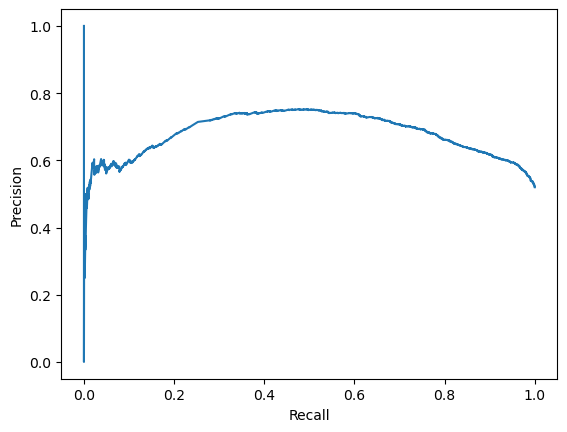

/var/folders/j2/5j3b6rgj5llcnsz3cgz6xqfm0000gq/T/ipykernel_18537/988179411.py:17: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


IndexError: index 3180 is out of bounds for axis 0 with size 3180

In [38]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np


y_probs = svm_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Find the threshold with the highest F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(precision)
best_threshold = thresholds[best_threshold_index]

# Make predictions with the best threshold
y_pred = (y_probs <= best_threshold).astype(int)

In [ ]:
print(best_threshold)

print(np.argmax(precision))

svm_testing_report = classification_report(y_test, y_pred)

# Print the classification report
print(svm_testing_report)

In [ ]:
X_test

In [59]:
for x in range(1,100,1):
    threshold=float(x)/100
    print(threshold)
    y_pred = (y_probs >= threshold).astype(int)
    svm_testing_report = classification_report(y_test, y_pred)

    # Print the classification report
    print(svm_testing_report)
    
    

0.01
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       232
         1.0       0.54      1.00      0.70       270

    accuracy                           0.54       502
   macro avg       0.27      0.50      0.35       502
weighted avg       0.29      0.54      0.38       502

0.02
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       232
         1.0       0.54      1.00      0.70       270

    accuracy                           0.54       502
   macro avg       0.27      0.50      0.35       502
weighted avg       0.29      0.54      0.38       502

0.03
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       232
         1.0       0.54      1.00      0.70       270

    accuracy                           0.54       502
   macro avg       0.27      0.50      0.35       502
weighted avg       0.29      0.54      0.38       502

0.04

/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/op